# Installing Required Depedency
The process contains command to install kaggle, torchsampler, and scikit-learn libraries using python package manager (PIP).

In [ ]:
!pip install -q kaggle
!pip install torchsampler
!pip install scikit-learn
!pip install seaborn
!pip install efficientnet_pytorch

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 960.0 kB/s eta 0:00:01
   --------------- ------------------------ 112.6/294.9 kB 1.6 MB/s eta 0:00:01
   -------------------------- ------------- 194.6/294.9 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.7 MB/s eta 0:00:00


# Download and Unzip Dataset
This process will perform action to download dataset using kaggle API token and extract zipped dataset.

In [ ]:
from google.colab import files

files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:27<00:00, 23.8MB/s]
100% 586M/586M [00:27<00:00, 22.3MB/s]


In [ ]:
!unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

# Explore Dataset
Here we start to getting detail information about the dataset starting from class amounts, total samples, class distribution and perform image augmentation.

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split

# Image Agumentation
data_transforms = transforms.Compose([
  transforms.RandomResizedCrop((150, 150)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
])

data_dir = 'raw-img'
img_datasets = datasets.ImageFolder(data_dir, data_transforms)
class_names = img_datasets.classes
dataset_sizes = len(img_datasets)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def show_sample_images(img_datasets):
  data_loader = DataLoader(img_datasets, batch_size=4)
  dataset = data_loader.dataset
  class_names = dataset.classes
  classes_index = dataset.class_to_idx.values()

  sample_images = []

  for class_idx in classes_index:
      for img in dataset.imgs:
          if img[1] == class_idx:
              sample_images.append(img)
              break

  fig= plt.figure(figsize=(20, 20))
  rows = int(len(sample_images) // 2)
  cols = 5

  for i, (img_path, label) in enumerate(sample_images):
      image = Image.open(img_path)
      image = image.resize((200, 200))
      image = np.asarray(image)
      fig.add_subplot(rows, cols, i+1)
      plt.imshow(image)
      plt.title(class_names[label])
      plt.tight_layout()

  plt.show()

show_sample_images(img_datasets)

In [ ]:
print(f"Total samples: {dataset_sizes}")
print(f"Classes: {class_names}")
print(f"Class Numbers: {len(class_names)}")

Total samples: 26179
Classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Class Numbers: 10


In [ ]:
def count_class_samples(dataset):
  class_names = dataset.classes
  class_counts = {}
  for _, label in dataset:
      class_name = class_names[label]
      if class_name not in class_counts:
          class_counts[class_name] = 0
      class_counts[class_name] += 1
  return class_counts

class_samples = count_class_samples(img_datasets)

print("[Dataset Samples]")
for class_name, count in class_samples.items():
  print(f"Class '{class_name}': {count} samples")

[Dataset Samples]
Class 'cane': 4863 samples
Class 'cavallo': 2623 samples
Class 'elefante': 1446 samples
Class 'farfalla': 2112 samples
Class 'gallina': 3098 samples
Class 'gatto': 1668 samples
Class 'mucca': 1866 samples
Class 'pecora': 1820 samples
Class 'ragno': 4821 samples
Class 'scoiattolo': 1862 samples


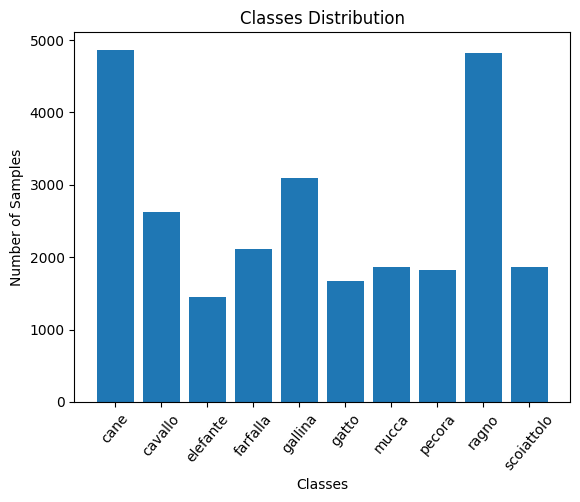

In [ ]:
plt.bar(class_samples.keys(), class_samples.values())
plt.xticks(rotation=50)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Classes Distribution')
plt.show()

# Spliting Dataset

Here we will split the dataset with certain percentages :

*   Train : 80%
*   Validation : 15%
*   Test : 5%



In [ ]:
from torch.utils.data import random_split

train_size = 0.8
val_size = 0.15
test_size = 0.05

train_dataset, val_dataset, test_dataset = random_split(img_datasets, [train_size, val_size, test_size])

In [ ]:
from collections import defaultdict

def count_splitted_class_samples(dataset):
  original_dataset = dataset.dataset
  class_counts = defaultdict(int)

  # Iterate through the dataset and count occurrences of each class
  for index in dataset.indices:
      _, target = original_dataset[index]
      class_counts[original_dataset.classes[target]] += 1

  return class_counts

def print_splitted_class_samples(class_counts):
  # Print the counts for each class
  for class_name, count in class_counts.items():
      print(f"Class '{class_name}': {count} samples")

  sum_data = sum([count for class_name, count in class_counts.items()])
  print(f"Total Count : {sum_data}")

train_class_samples = count_splitted_class_samples(train_dataset)
val_class_samples = count_splitted_class_samples(val_dataset)
test_class_samples = count_splitted_class_samples(test_dataset)

print("[Train Samples]")
print_splitted_class_samples(train_class_samples)
print("\n[Validation Samples]")
print_splitted_class_samples(val_class_samples)
print("\n[Test Samples]")
print_splitted_class_samples(test_class_samples)

[Train Samples]
Class 'cane': 3879 samples
Class 'farfalla': 1688 samples
Class 'pecora': 1462 samples
Class 'gallina': 2491 samples
Class 'gatto': 1318 samples
Class 'cavallo': 2083 samples
Class 'elefante': 1172 samples
Class 'scoiattolo': 1508 samples
Class 'ragno': 3853 samples
Class 'mucca': 1490 samples
Total Count : 20944

[Validation Samples]
Class 'ragno': 721 samples
Class 'elefante': 200 samples
Class 'scoiattolo': 274 samples
Class 'gallina': 462 samples
Class 'cavallo': 403 samples
Class 'gatto': 250 samples
Class 'farfalla': 314 samples
Class 'cane': 735 samples
Class 'mucca': 289 samples
Class 'pecora': 279 samples
Total Count : 3927

[Test Samples]
Class 'scoiattolo': 80 samples
Class 'cane': 249 samples
Class 'gatto': 100 samples
Class 'ragno': 247 samples
Class 'gallina': 145 samples
Class 'cavallo': 137 samples
Class 'pecora': 79 samples
Class 'elefante': 74 samples
Class 'mucca': 87 samples
Class 'farfalla': 110 samples
Total Count : 1308


In [ ]:
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 20944
Validation samples: 3927
Test samples: 1308


# Balance Sampling Dataset
Because we found the dataset have different class samples distribution, here we sampling the dataset to make per-class samples are balanced.

In [ ]:
from torchsampler import ImbalancedDatasetSampler

batch_size = 40
train_dl = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset, labels=[label for _, label in train_dataset]))
val_dl = DataLoader(val_dataset, batch_size=batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

print(f"Total balance sampled train data : {len(train_dl.dataset)}")

Total balance sampled train data : 20944


In [ ]:
from collections import defaultdict

# Get class names from the dataset
class_names = train_dataset.dataset.classes

# Dictionary to store counts of each class
class_counts = defaultdict(int)

# Iterate through the DataLoader and count occurrences of each class
for _, labels in train_dl:
    for label in labels:
        class_name = class_names[label.item()]
        class_counts[class_name] += 1

# Print the counts for each class
print("[Train Samples]")
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} samples")

[Train Samples]
Class 'pecora': 2072 samples
Class 'mucca': 2088 samples
Class 'farfalla': 2109 samples
Class 'cavallo': 2085 samples
Class 'ragno': 2149 samples
Class 'cane': 2073 samples
Class 'gatto': 2163 samples
Class 'scoiattolo': 2067 samples
Class 'elefante': 2047 samples
Class 'gallina': 2091 samples


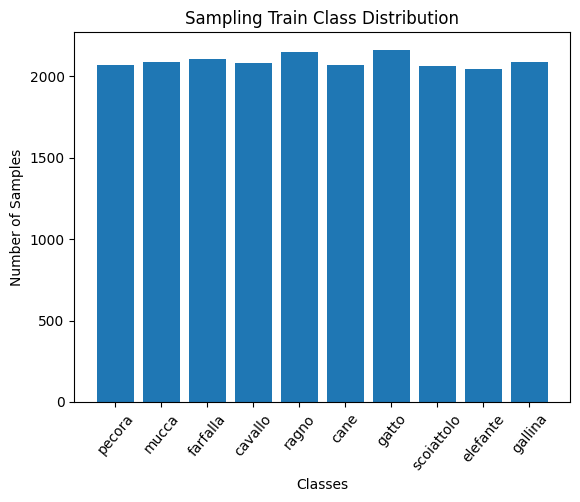

In [ ]:
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=50)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Sampling Train Class Distribution')
plt.show()

# Construct The Model
Here, we define the model architecture to fit by the dataset.

In [ ]:
import time
import copy
import torch.nn as nn
import torch.optim as optim

def get_device():
  if torch.cuda.is_available(): # For Nvidia GPU
    return torch.device("cuda:0")
  elif torch.backends.mps.is_available(): # For Mac Silicon & AMD
    return torch.device("mps")
  else:
    return torch.device("cpu")

device = get_device()

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    '''
    Function that will train model based on data provided.
    '''

    since = time.time()

    # Make a deep copy of the model provided
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Logging Variables
    train_logs = {
        'loss': [],
        'acc': []
    }
    val_logs = {
        'loss': [],
        'acc': []
    }

    for epoch in range(num_epochs):
        epoch_start = time.time()  # Record the start time of the epoch
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data using the dataloader we defined
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass, tracking history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Computing loss statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                if (scheduler != None):
                  scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)

            # Logging statistics
            if phase == 'train':
                train_logs['loss'].append(epoch_loss)
                train_logs['acc'].append(epoch_acc)
            else:
                val_logs['loss'].append(epoch_loss)
                val_logs['acc'].append(epoch_acc)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Create a deep copy of the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_time_elapsed = time.time() - epoch_start  # Calculate epoch time
        print(f'Epoch time elapsed: {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s')

        print() # Print an empty line for nice formatting


    metrics_logs = {}
    metrics_logs['train'] = train_logs
    metrics_logs['val'] = val_logs
    total_time_elapsed = time.time() - since
    print(f'Training complete in {total_time_elapsed // 60:.0f}m {total_time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_logs

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class AnimalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 756, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(756 * 4 * 4, 756)
        self.fc2 = nn.Linear(756, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 756 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Create an instance of the model
model = AnimalModel()

# Print the model summary
print(model)

AnimalModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 756, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12096, out_features=756, bias=True)
  (fc2): Linear(in_features=756, out_features=10, bias=True)
)


In [ ]:
print(device)

cuda:0


# Training The Model

From the constructed model here we train the model using several learning rate to determine best model accuracy.

In [ ]:
learning_rates = [0.001, 0.0001, 0.00001]
train_activities = []

dataloaders = {
    'train': train_dl,
    'val': val_dl
}

for lr in learning_rates:
  model = AnimalModel().to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)
  # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  # Train the model
  print(f"Learning rate {lr}")
  trained_model, logs = train_model(model, dataloaders, criterion, optimizer, None, num_epochs=25)
  print()
  train_activities.append({
      'model': trained_model,
      'metric': logs
  })

Learning rate 0.001
Epoch 0/24
----------
train Loss: 2.1494 Acc: 0.1952
val Loss: 1.9787 Acc: 0.2592
Epoch time elapsed: 0m 56s

Epoch 1/24
----------
train Loss: 1.8883 Acc: 0.3237
val Loss: 1.7866 Acc: 0.3471
Epoch time elapsed: 0m 58s

Epoch 2/24
----------
train Loss: 1.7263 Acc: 0.3902
val Loss: 1.6919 Acc: 0.3993
Epoch time elapsed: 0m 57s

Epoch 3/24
----------
train Loss: 1.5903 Acc: 0.4428
val Loss: 1.6176 Acc: 0.4046
Epoch time elapsed: 0m 56s

Epoch 4/24
----------
train Loss: 1.4514 Acc: 0.4948
val Loss: 1.4080 Acc: 0.4930
Epoch time elapsed: 0m 57s

Epoch 5/24
----------
train Loss: 1.3689 Acc: 0.5186
val Loss: 1.3483 Acc: 0.5230
Epoch time elapsed: 0m 55s

Epoch 6/24
----------
train Loss: 1.2898 Acc: 0.5527
val Loss: 1.2955 Acc: 0.5577
Epoch time elapsed: 0m 58s

Epoch 7/24
----------
train Loss: 1.2301 Acc: 0.5729
val Loss: 1.2097 Acc: 0.5796
Epoch time elapsed: 0m 56s

Epoch 8/24
----------
train Loss: 1.1723 Acc: 0.5952
val Loss: 1.2347 Acc: 0.5584
Epoch time elapsed

# Loss and Accuracy Table

To gaining information about the model performance, we visualize train and validation logs.

In [ ]:
for activity in train_activities:
  val_accuracy = [acc.cpu().numpy() for acc in activity['metric']['val']['acc']]
  val_accuracy.sort()
  print(f"Learning rate lr={learning_rates[train_activities.index(activity)]}, val accuracy: {val_accuracy[-1]:4f}")

Learning rate lr=0.001, val accuracy: 0.683473
Learning rate lr=0.0001, val accuracy: 0.659282
Learning rate lr=1e-05, val accuracy: 0.410491


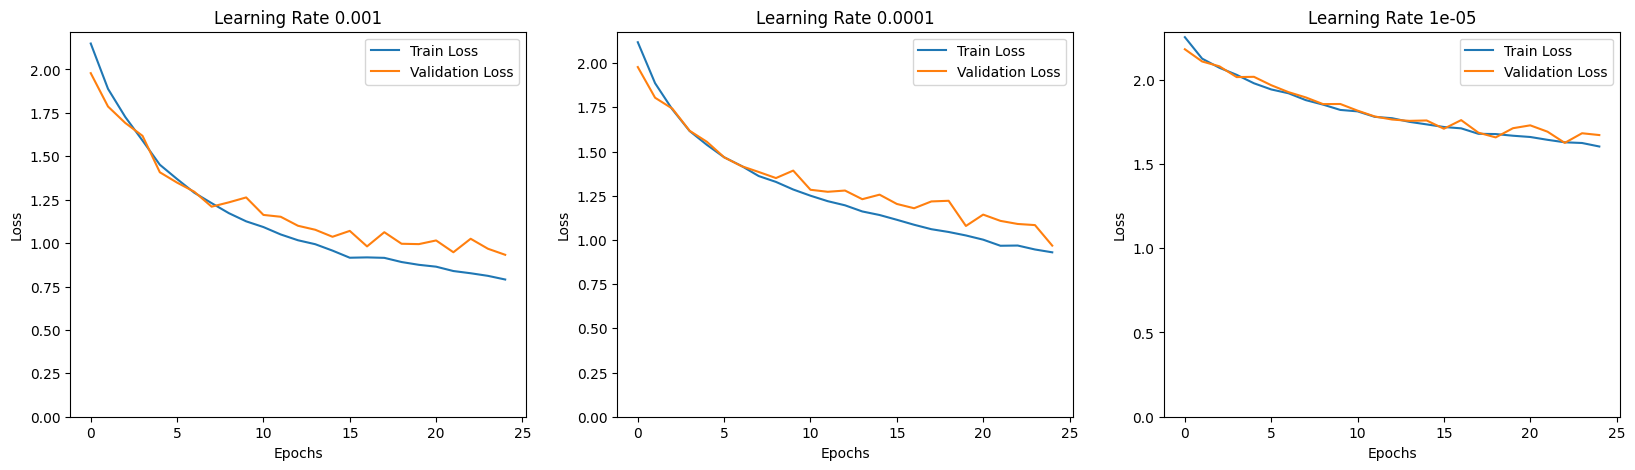

In [ ]:
fig = plt.figure(figsize=(20, 5))

for activity in train_activities:
  fig.add_subplot(1, 3, train_activities.index(activity) + 1)
  plt.plot(activity['metric']['train']['loss'], label='Train Loss')
  plt.plot(activity['metric']['val']['loss'], label='Validation Loss')
  plt.title(f'Learning Rate {learning_rates[train_activities.index(activity)]}')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.ylim(0)
  plt.legend()

plt.show()

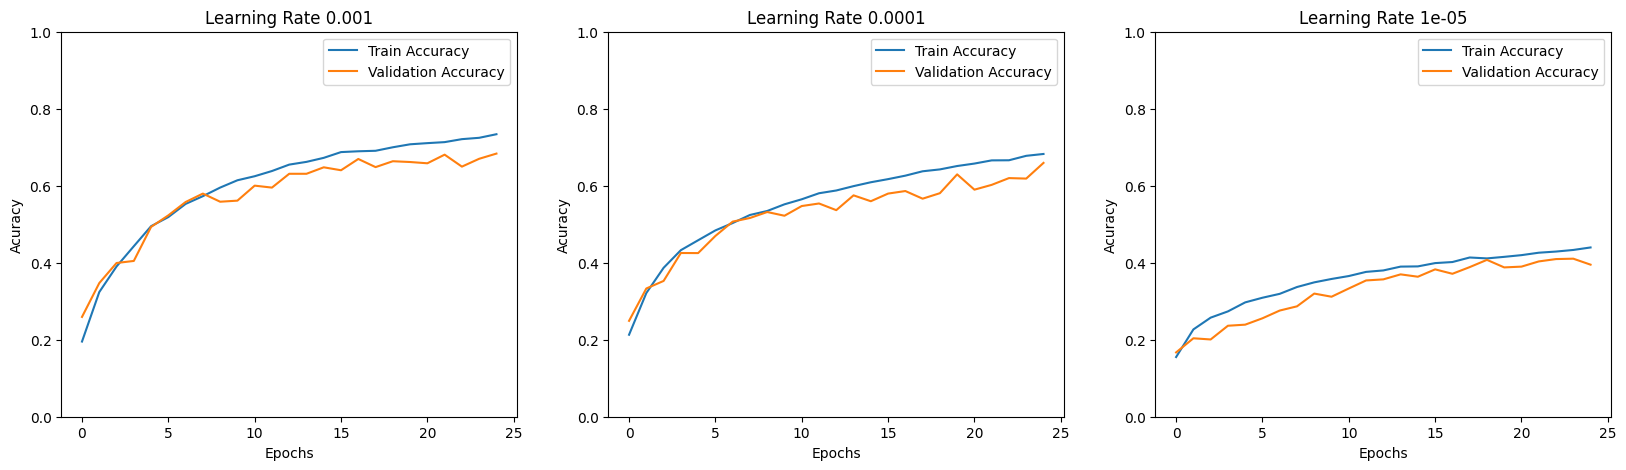

In [ ]:
fig = plt.figure(figsize=(20, 5))

for activity in train_activities:
  train_accuracy = [acc.cpu().numpy() for acc in activity['metric']['train']['acc']]
  val_accuracy = [acc.cpu().numpy() for acc in activity['metric']['val']['acc']]

  fig.add_subplot(1, 3, train_activities.index(activity) + 1)
  plt.plot(train_accuracy, label='Train Accuracy')
  plt.plot(val_accuracy, label='Validation Accuracy')
  plt.title(f'Learning Rate {learning_rates[train_activities.index(activity)]}')
  plt.xlabel('Epochs')
  plt.ylabel('Acuracy')
  plt.ylim(0, 1)
  plt.legend()

plt.show()

# Confusion Matrix Table

Visualizing test predictions confusion matrix from best trained model.

In [ ]:
best_val_acc = 0
best_model = None

for activity in train_activities:
  val_accuracy = [acc.cpu().numpy() for acc in activity['metric']['val']['acc']]
  val_accuracy.sort()
  if val_accuracy[-1] > best_val_acc:
    best_val_acc = val_accuracy[-1]
    best_model = activity['model']

print(f"Best validation accuracy: {best_val_acc:4f}")
print(best_model)

Best validation accuracy: 0.683473
AnimalModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 756, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=12096, out_features=756, bias=True)
  (fc2): Linear(in_features=756, out_features=10, bias=True)
)


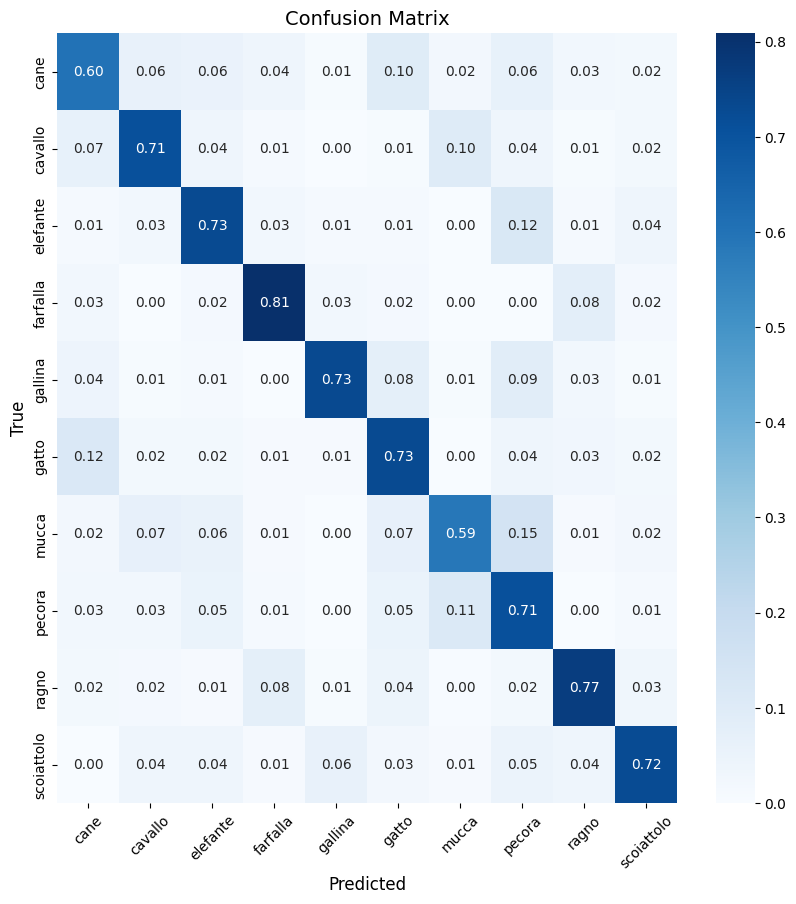

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for test data
y_pred = []
y_true = []

for inputs, labels in test_dl:
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = best_model(inputs)
  _, preds = torch.max(outputs, 1)
  y_pred.extend(preds.cpu().numpy())
  y_true.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax, cmap="Blues")

# Set labels and title
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Set tick labels for x-axis and y-axis
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


# Construct Pretrained Model
We use EfficientNet B0 for this classification problem.

In [ ]:
import torchvision.models as models
import torch.nn as nn

def build_model(pretrained=True, fine_tune=True, num_classes=10):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

In [ ]:
model = build_model(
    pretrained=True,
    fine_tune=True,
    num_classes=len(class_names)
).to(device)

print(model)

[INFO]: Loading pre-trained weights
[INFO]: Fine-tuning all layers...
EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (sca

C:\Users\Tech\Documents\animal-classification\py-venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Tech\Documents\animal-classification\py-venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Training Model
Train new model using transfer learning method from EfficientNet B0.

In [ ]:
learning_rate = 0.001

batch_size = 24
train_dl = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset, labels=[label for _, label in train_dataset]))
val_dl = DataLoader(val_dataset, batch_size=batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

dataloaders = {
    'train': train_dl,
    'val': val_dl
}

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
trained_model, logs = train_model(model, dataloaders, criterion, optimizer, None, num_epochs=14)

Epoch 0/13
----------
train Loss: 0.6923 Acc: 0.7739
val Loss: 0.6027 Acc: 0.8139
Epoch time elapsed: 1m 43s

Epoch 1/13
----------
train Loss: 0.5345 Acc: 0.8257
val Loss: 0.4802 Acc: 0.8429
Epoch time elapsed: 1m 41s

Epoch 2/13
----------
train Loss: 0.4853 Acc: 0.8389
val Loss: 0.4145 Acc: 0.8678
Epoch time elapsed: 1m 42s

Epoch 3/13
----------
train Loss: 0.4523 Acc: 0.8528
val Loss: 0.4295 Acc: 0.8643
Epoch time elapsed: 1m 42s

Epoch 4/13
----------
train Loss: 0.4338 Acc: 0.8583
val Loss: 0.4235 Acc: 0.8538
Epoch time elapsed: 1m 41s

Epoch 5/13
----------
train Loss: 0.4118 Acc: 0.8681
val Loss: 0.4060 Acc: 0.8638
Epoch time elapsed: 1m 43s

Epoch 6/13
----------
train Loss: 0.4005 Acc: 0.8686
val Loss: 0.3822 Acc: 0.8750
Epoch time elapsed: 1m 42s

Epoch 7/13
----------
train Loss: 0.3803 Acc: 0.8738
val Loss: 0.3718 Acc: 0.8846
Epoch time elapsed: 1m 42s

Epoch 8/13
----------
train Loss: 0.3722 Acc: 0.8767
val Loss: 0.3962 Acc: 0.8653
Epoch time elapsed: 1m 42s

Epoch 9/13

# Visualiszing Loss and Accuracy

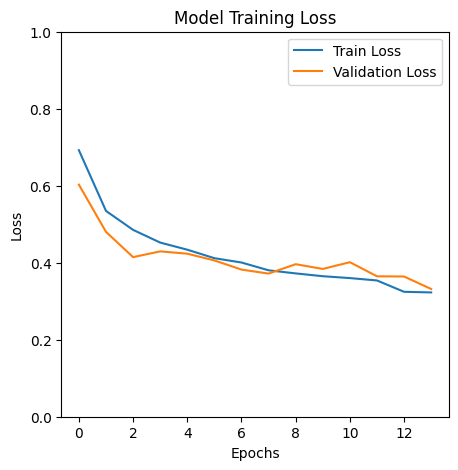

In [ ]:
fig = plt.figure(figsize=(5, 5))

plt.plot(logs['train']['loss'], label='Train Loss')
plt.plot(logs['val']['loss'], label='Validation Loss')
plt.title(f'Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.show()

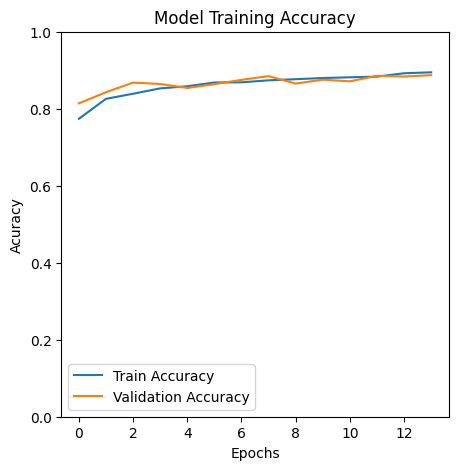

In [ ]:
fig = plt.figure(figsize=(5, 5))

train_accuracy = [acc.cpu().numpy() for acc in logs['train']['acc']]
val_accuracy = [acc.cpu().numpy() for acc in logs['val']['acc']]

plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title(f'Model Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

# Visualizing Confusion Matrix
Show prediction result from transfer learning model.

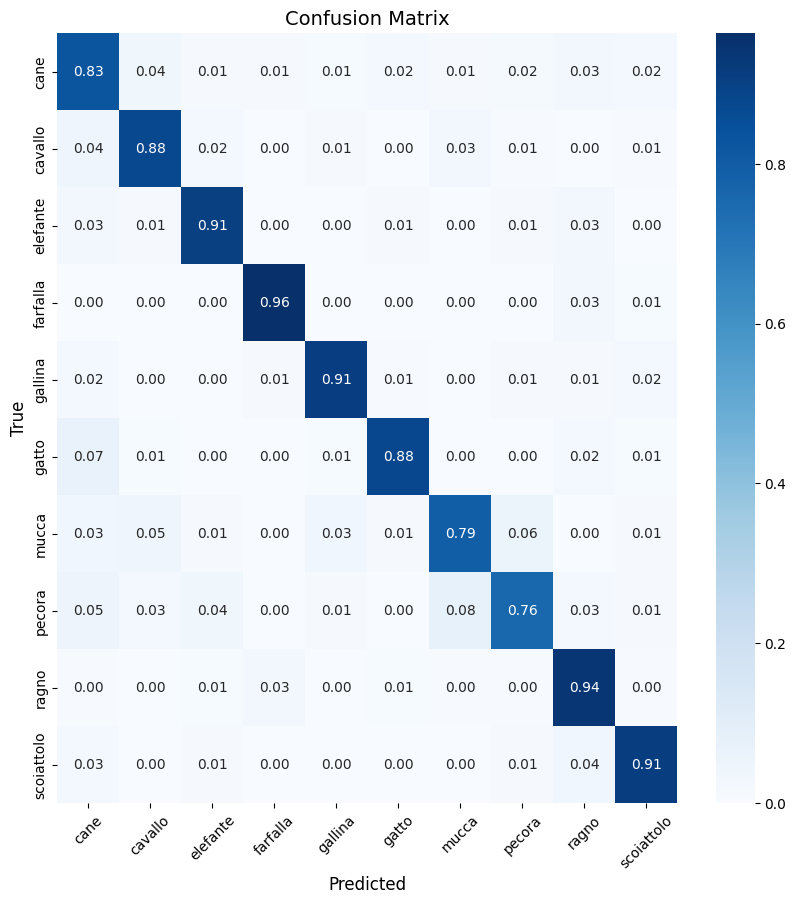

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for test data
y_pred = []
y_true = []

for inputs, labels in test_dl:
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = trained_model(inputs)
  _, preds = torch.max(outputs, 1)
  y_pred.extend(preds.cpu().numpy())
  y_true.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax, cmap="Blues")

# Set labels and title
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Set tick labels for x-axis and y-axis
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Constructing New Generation of Pretrained Model
After few exploration, we decided to use new generation of EfficientNet B3.

In [ ]:
from efficientnet_pytorch import EfficientNet

model_name = 'efficientnet-b3'
model = EfficientNet.from_pretrained(model_name, num_classes=len(class_names)).to(device)
model

Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

# Training New Generation Pretrained Model
We adjust the learning rate and batch size for this model to increase accuracy.

In [ ]:
learning_rate = 0.0001

batch_size = 32
train_dl = DataLoader(train_dataset, batch_size=batch_size, sampler=ImbalancedDatasetSampler(train_dataset, labels=[label for _, label in train_dataset]))
val_dl = DataLoader(val_dataset, batch_size=batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size)

dataloaders = {
    'train': train_dl,
    'val': val_dl
}

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
trained_model, logs = train_model(model, dataloaders, criterion, optimizer, None, num_epochs=8)

Epoch 0/7
----------
train Loss: 0.5708 Acc: 0.8433
val Loss: 0.2159 Acc: 0.9389
Epoch time elapsed: 2m 21s

Epoch 1/7
----------
train Loss: 0.2706 Acc: 0.9147
val Loss: 0.1963 Acc: 0.9437
Epoch time elapsed: 2m 21s

Epoch 2/7
----------
train Loss: 0.2150 Acc: 0.9312
val Loss: 0.1741 Acc: 0.9478
Epoch time elapsed: 2m 21s

Epoch 3/7
----------
train Loss: 0.1977 Acc: 0.9372
val Loss: 0.1643 Acc: 0.9463
Epoch time elapsed: 2m 22s

Epoch 4/7
----------
train Loss: 0.1888 Acc: 0.9395
val Loss: 0.1663 Acc: 0.9509
Epoch time elapsed: 2m 21s

Epoch 5/7
----------
train Loss: 0.1662 Acc: 0.9450
val Loss: 0.1780 Acc: 0.9450
Epoch time elapsed: 2m 20s

Epoch 6/7
----------
train Loss: 0.1572 Acc: 0.9479
val Loss: 0.1706 Acc: 0.9450
Epoch time elapsed: 2m 22s

Epoch 7/7
----------
train Loss: 0.1482 Acc: 0.9531
val Loss: 0.1706 Acc: 0.9463
Epoch time elapsed: 2m 20s

Training complete in 18m 50s
Best val Acc: 0.950853


# Visualizing Loss and Accuracy

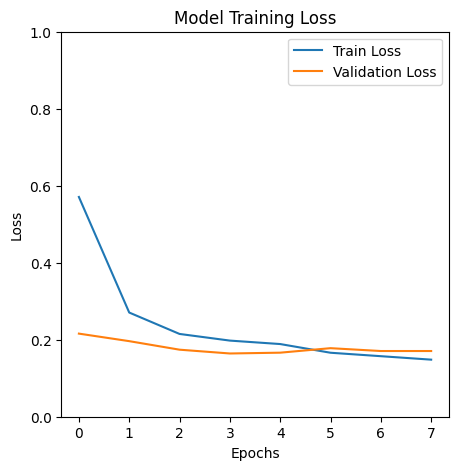

In [ ]:
fig = plt.figure(figsize=(5, 5))

plt.plot(logs['train']['loss'], label='Train Loss')
plt.plot(logs['val']['loss'], label='Validation Loss')
plt.title(f'Model Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.show()

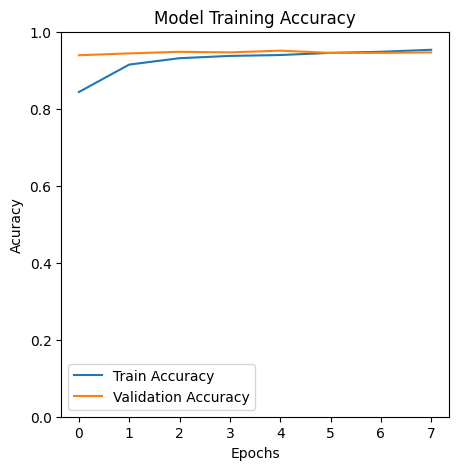

In [ ]:
fig = plt.figure(figsize=(5, 5))

train_accuracy = [acc.cpu().numpy() for acc in logs['train']['acc']]
val_accuracy = [acc.cpu().numpy() for acc in logs['val']['acc']]

plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title(f'Model Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')
plt.ylim(0, 1)
plt.legend()

plt.show()

# Visualizing Model Prediction Confusion Matrix

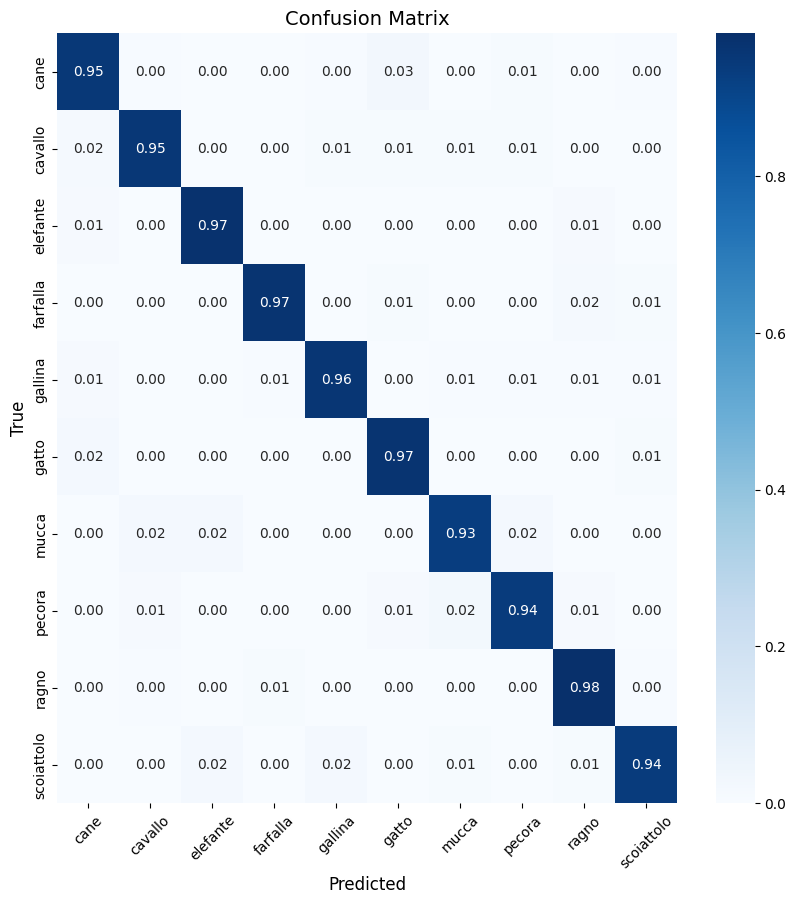

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions for test data
y_pred = []
y_true = []

for inputs, labels in test_dl:
  inputs = inputs.to(device)
  labels = labels.to(device)

  outputs = trained_model(inputs)
  _, preds = torch.max(outputs, 1)
  y_pred.extend(preds.cpu().numpy())
  y_true.extend(labels.cpu().numpy())

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt=".2f", ax=ax, cmap="Blues")

# Set labels and title
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('True', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

# Set tick labels for x-axis and y-axis
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()